In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from xgboost import DMatrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import hyperopt
from hyperopt import fmin, tpe, hp

In [2]:
train = pd.read_csv("D:\\Kaggle\\titanic\\train.csv")
test = pd.read_csv("D:\\Kaggle\\titanic\\test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocesamiento train

#### Aqui se imputan los valores faltantes,  se agrupan las variables numerias, se codifica las variables categoricas. Se borran algunas columnas

In [3]:
train['Age'] = train['Age'].fillna(round(train['Age'].mean()))
train['Age_group'] = pd.cut(train['Age'], bins=[0, 20, 40, 60, 80], labels=[1, 2, 3, 4])
train = pd.get_dummies(train, columns=['Sex'])
columna = ['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked']
train_1 = train.drop(columns=columna)
train_1.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Age_group,Sex_female,Sex_male
0,1,0,3,1,0,2,0,1
1,2,1,1,1,0,2,1,0
2,3,1,3,0,0,2,1,0
3,4,1,1,1,0,2,1,0
4,5,0,3,0,0,2,0,1


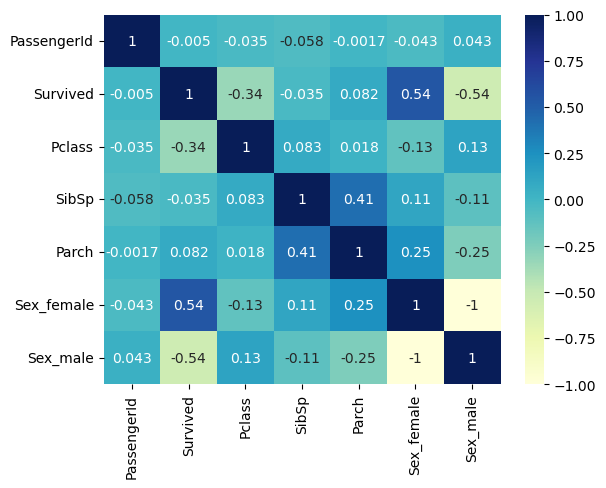

In [4]:
# Observando las correlaciones entre caracteristicas
sns.heatmap(train_1.corr(), cmap='YlGnBu', annot=True)
plt.show()

## Preprocesamiento test
#### Aqui se imputan los valores faltantes,  se agrupan las variables numerias, se codifica las variables categoricas. Se borran algunas columnas y se escalan las demas caracteristicas 

In [5]:
test['Age'] = test['Age'].fillna(round(test['Age'].mean()))
test['Age_group'] = pd.cut(test['Age'], bins=[0, 20, 40, 60, 80], labels=[1, 2, 3, 4])
test = pd.get_dummies(test, columns=['Sex'])

columna_test = ['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked']
test = test.drop(columns=columna_test)
test.set_index('PassengerId', inplace=True)
columns_test = test.columns
scaler = StandardScaler()
test[columns_test] = scaler.fit_transform(test[columns_test])
test.head()

,Pclass,SibSp,Parch,Age_group,Sex_female,Sex_male
PassengerId,,,,,,
892,0.873482,-0.499470,-0.400248,-0.069629,-0.755929,0.755929
893,0.873482,0.616992,-0.400248,1.462206,1.322876,-1.322876
894,-0.315819,-0.499470,-0.400248,2.994040,-0.755929,0.755929
895,0.873482,-0.499470,-0.400248,-0.069629,-0.755929,0.755929
896,0.873482,0.616992,0.619896,-0.069629,1.322876,-1.322876


In [6]:
# Se eliminan algunos valores atipicos
from sklearn.neighbors import LocalOutlierFactor

local = LocalOutlierFactor(contamination = 0.02)

out = local.fit_predict(train_1)

train_12 = train_1[np.where(out == 1, True, False)]
train_12.shape

(873, 8)

In [7]:
# Se hace la division entre caracteristicas y etiqueta

# Datos de entrenamiento
X = train_12.drop(columns='Survived')
y = train_12.Survived

1    537
0    537
Name: Survived, dtype: int64


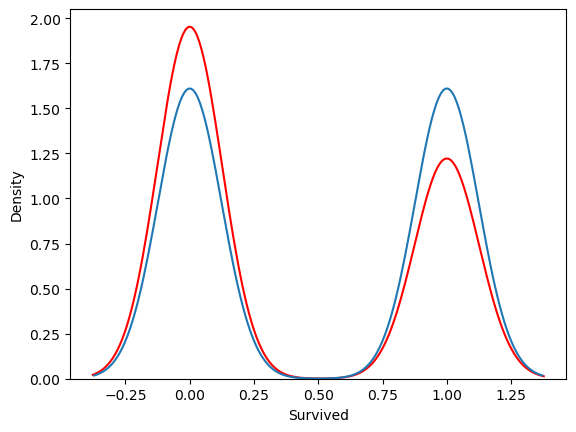

In [8]:
# Se usa SMOTE para realizar el sobremuestreo para equilibrar 
from imblearn.over_sampling import SMOTE
smote = SMOTE( random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)
print(y_resampled.value_counts())

sns.kdeplot(y, label = "Original" , color = 'red')
sns.kdeplot(y_resampled, label = "Modified")
X = X_resampled
y = y_resampled

In [9]:
# Se transforma PassengerId como indice para el entrenamiento
X.set_index('PassengerId', inplace=True)
columns = X.columns

In [10]:
# Se escalan los datos de entrenamiento y se preparan para que los modelos de ML los reciban

# Datos de entrenamiento
scaler = StandardScaler()
X[columns] = scaler.fit_transform(X[columns])
y = np.ravel(y)

In [11]:
#Escogemos 5 modelos (Logistic Regression, SVC, Random Forest Classifier, Stochastic Gradient y Xgboost)
#los ajustamos y se observa el accuracy de entrenamiento para tener una base

models = {"Logistic Regression": LogisticRegression(), "SVM": SVC(), 
          "Random Forest": RandomForestClassifier(), "Stochastic Gradient": SGDClassifier(random_state=12)}
for name, model in models.items():
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    cv = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    print("{} Cross validation: {}".format(name, cv.mean()))
    
churn_dmatrix = xgb.DMatrix(X, y)
params = {"objective": "binary:logistic", "max_depth":4}
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, nfold=5, num_boost_round=10, metrics="error", as_pandas=True, seed=42)
print("Xgboost Train Set Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))

Logistic Regression Cross validation: 0.8101151923494893
SVM Cross validation: 0.8296326885459683
Random Forest Cross validation: 0.8156574657683112
Stochastic Gradient Cross validation: 0.7858204738100414
Xgboost Train Set Accuracy: 0.826842


### Ajuste de Hiperparametros
#### Se usa la libreria hyperopt para ajustar los hiperparametros de cada modelo

In [12]:
# Logistic Regression
space= {'C': hp.loguniform('C', np.log(0.001), np.log(100)),
        'penalty': hp.choice('penalty', ['l2']),
          'solver': hp.choice('solver', ['lbfgs', 'liblinear', 'saga'])}

def objective(params):
    params = {'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver']}
    lr_clf = LogisticRegression(random_state=42, max_iter=1000, **params)
    score = cross_val_score(lr_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return -score

best = fmin(fn=objective, space=space, max_evals=500, rstate=np.random.default_rng(42), algo=tpe.suggest)

print('Mejores hiperparámetros encontrados:')
print(best)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.55trial/s, best loss: -0.808259074114323]
Mejores hiperparámetros encontrados:
{'C': 0.002335098082717584, 'penalty': 0, 'solver': 0}


In [13]:
# SVM
space_svc = {'C': hp.loguniform('C', np.log(0.001), np.log(1000)),
             'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])}

def objective_svc(params_svc):
    params_svc = {'C': params_svc['C'], 'kernel': params_svc['kernel']}
    svc_clf = SVC(random_state=42, max_iter=1000, **params_svc)
    score_svc = cross_val_score(svc_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return -score_svc

best_svc = fmin(fn=objective_svc, space=space_svc, max_evals=500, rstate=np.random.default_rng(42), algo=tpe.suggest)
print('Mejores hiperparámetros encontrados:')
print(best_svc)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.21trial/s, best loss: -0.8324668550315149]
Mejores hiperparámetros encontrados:
{'C': 0.3206672236646401, 'kernel': 2}


In [14]:
#Random Forest Classifier
space_rf= {'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
        'max_depth': hp.quniform('max_depth', 1, 20, 2),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 2),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 2), 
         'max_features': hp.choice('max_features', ['log2', 'sqrt', 'auto'])}

def objective_rf(params_rf):
    params_rf = {'n_estimators': int(params_rf['n_estimators']), 'max_depth': int(params_rf['max_depth']), 
                 'min_samples_leaf': int(params_rf['min_samples_leaf']), 
                 'min_samples_split': int(params_rf['min_samples_split']), 'max_features': params_rf['max_features']}
    rf_clf = RandomForestClassifier(random_state=42, **params_rf)
    score_rf = cross_val_score(rf_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return -score_rf

best_rf = fmin(fn=objective_rf, space=space_rf, max_evals=100, rstate=np.random.default_rng(42), algo=tpe.suggest)

print('Mejores hiperparámetros encontrados:')
print(best_rf)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64trial/s, best loss: -0.8278113453597044]
Mejores hiperparámetros encontrados:
{'max_depth': 12.0, 'max_features': 2, 'min_samples_leaf': 14.0, 'min_samples_split': 8.0, 'n_estimators': 80.0}


In [15]:
# Stochastic Gradient
space_sgd= {'alpha': hp.uniform('alpha', 0.0001, 1),
        'tol': hp.uniform('tol', 0.000001, 0.001)}

def objective_sgd(params_sgd):
    params_sgd = {'alpha': params_sgd['alpha'], 'tol': params_sgd['tol']}
    sgd_clf = SGDClassifier(random_state=42, **params_sgd, max_iter=1000, learning_rate='optimal', 
                                    loss='modified_huber')
    score_sgd = cross_val_score(sgd_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return -score_sgd

best_sgd = fmin(fn=objective_sgd, space=space_sgd, max_evals=500, rstate=np.random.default_rng(42), algo=tpe.suggest)

print('Mejores hiperparámetros encontrados:')
print(best_sgd)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.05trial/s, best loss: -0.8157096283416649]
Mejores hiperparámetros encontrados:
{'alpha': 0.6201569857768734, 'tol': 0.0008138417522326476}


In [16]:
# XGBoosting

housing_dmatrix = xgb.DMatrix(data=X,label=y)

space_xgb = {'learning_rate': hp.uniform('learning_rate', 0.001, 1), 
             'max_depth': hp.quniform('max_depth', 2, 10, 1), 'n_estimators': hp.quniform('n_estimators', 10, 500, 20), 
              'subsample': hp.loguniform('subsample', np.log(0.1), np.log(1)),  
              'colsample_bytree': hp.loguniform('colsample_bytree', np.log(0.1), np.log(1)),
              'reg_alpha': hp.quniform('reg_alpha', 0, 10, 1), 'reg_lambda': hp.quniform('reg_lambda', 0, 10, 1)}

def objective_xgb (params_xgb):
    params_xgb = {'learning_rate': params_xgb['learning_rate'], 'max_depth': int(params_xgb['max_depth']),
                   'n_estimators': int(params_xgb['n_estimators']), 'subsample': params_xgb['subsample'],
                   'colsample_bytree': params_xgb['colsample_bytree'], 'reg_alpha': params_xgb['reg_alpha'],
                    'reg_lambda': params_xgb['reg_lambda']}
    xgb_clf = xgb.XGBClassifier(random_state=42, **params_xgb)
    score_xgb = cross_val_score(xgb_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return -score_xgb

best_xgb = fmin(fn=objective_xgb, space=space_xgb, max_evals=500, rstate=np.random.default_rng(42), algo=tpe.suggest)

print('Mejores hiperparámetros encontrados:')
print(best_xgb)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:42<00:00,  4.87trial/s, best loss: -0.8352575527059335]
Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.3337030421688588, 'learning_rate': 0.32876868907971485, 'max_depth': 10.0, 'n_estimators': 420.0, 'reg_alpha': 1.0, 'reg_lambda': 4.0, 'subsample': 0.17930031108822564}


### Se toman los hiperparametros hallados y se usan en cada modelo

In [17]:
# Logistic Regression
#Opciones de ajuste
penalty_options = ['l2']
solver_options = ['lbfgs', 'liblinear', 'saga']


C_log = best['C']
penalty_log = penalty_options[best['penalty']]
solver_log = solver_options[best['solver']]

logreg = LogisticRegression(C= C_log, random_state=42, penalty=penalty_log, solver=solver_log, max_iter=1000)
logreg.fit(X, y)
train_score = logreg.score(X, y)
print('Train set accuracy:', train_score)

Train set accuracy: 0.8081936685288641


In [18]:
# SVC
#opciones de ajuste
kernel_options = ['linear', 'poly', 'rbf', 'sigmoid']

C_svc = best_svc['C']
kernel_svc = kernel_options[best_svc['kernel']]


svm = SVC(C=C_svc, random_state=42, kernel=kernel_svc)
svm.fit(X, y)
score_svm = svm.score(X, y)
print('Train set accuracy:', score_svm)

Train set accuracy: 0.8389199255121043


In [19]:
# Random Forest Classifier
#opciones de ajuste
max_features_options = ['log2', 'sqrt', 'auto']


max_depth_rf = best_rf['max_depth']
min_samples_leaf_rf = int(best_rf['min_samples_leaf'])
min_samples_split_rf = int(best_rf['min_samples_split'])
n_estimators_rf = int(best_rf['n_estimators'])
max_features_rf = max_features_options[best_rf['max_features']]

rf = RandomForestClassifier(max_depth=max_depth_rf, min_samples_leaf=min_samples_leaf_rf, 
                             min_samples_split=min_samples_split_rf, n_estimators=n_estimators_rf, 
                            random_state=42, max_features=max_features_rf)
rf.fit(X, y)
score_rf = rf.score(X, y)
print('Train set accuracy:', score_rf)

Train set accuracy: 0.8333333333333334


In [20]:
# Stochastic Gradient
sgd_ = SGDClassifier(**best_sgd, random_state=42, max_iter=1000, learning_rate='optimal', loss='modified_huber')
sgd_.fit(X, y)
score_sgd_ = sgd_.score(X, y)
print('Train set accuracy:', score_sgd_)

Train set accuracy: 0.8156424581005587


In [21]:
# XGBoosting
#opciones de ajuste
colsample_bytree = best_xgb['colsample_bytree']
learning_rate = best_xgb['learning_rate']
max_depth = int(best_xgb['max_depth'])
n_estimators = int(best_xgb['n_estimators'])
reg_alpha = best_xgb['reg_alpha']
reg_lambda = best_xgb['reg_lambda']
subsample = best_xgb['subsample']

xgb = xgb.XGBClassifier(random_state=42, colsample_bytree=colsample_bytree, learning_rate=learning_rate,  max_depth=max_depth,
                        n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda, subsample=subsample)
xgb.fit(X, y)
score_xgb = xgb.score(X, y)
print('Train set accuracy:', score_xgb)


Train set accuracy: 0.8389199255121043


### Se usa el modelo de ensamble Voting Classifier para tener mejores predicciones.

In [22]:
classifiers=[('Logistic Regression', logreg), ('Support Vector', svm), ('Random Forest', rf), ('stocastic', sgd_), 
              ('XGBoost', xgb)]
voting_clf = VotingClassifier(estimators=classifiers)
cv= cross_val_score(voting_clf, X, y, cv=5,  n_jobs=-1)
print('Cross validation:', cv)
print('Cross validation mean:', cv.mean())
voting_clf.fit(X, y)
accuracy_train = voting_clf.score(X, y)
print("La precisión (accuracy) del entrenamiento es: {:.2f}%".format(accuracy_train * 100))

Cross validation: [0.78604651 0.82325581 0.75813953 0.90232558 0.89719626]
Cross validation mean: 0.8333927407085415
La precisión (accuracy) del entrenamiento es: 83.43%


In [23]:
# Se hace un archivo con las predicciones para pasarlo a la plataforma Kaggle
preds = voting_clf.predict(test)
rta = pd.DataFrame({'PassengerId': test.index, 'Survived': preds})
rta.to_csv('best_rep.csv', index=False)

## Accuracy = 0.78468